# Easiest network-- predict Exclusive-OR
# Predict next input
- generate 1000 letter sequence containing d, b, g
- replace d, b, g with dii, ba, guuu

## network architecture
6 input units, 20 hidden units, 6 output units, 20 context units
# Hierarchical clustering analysis
### Read and Preprocess inputs

In [100]:
# Let's start with some packages we need
from __future__ import print_function
import torch
import torch.nn as nn
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
import re
import string
from nltk.stem import PorterStemmer

# Read the contents of the text file
with open("data/NCE2.txt", "r") as file:
    text = file.read()
    
def remove_non_ascii(s):
    return re.sub(r'[^\x00-\x7F]+|\d', '', s)

# Create a PorterStemmer object
stemmer = PorterStemmer()

# Splitting the text into sentences
sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s|\n', text)
sentences = [remove_non_ascii(item) for item in sentences]
print(sentences)

In [48]:
# Preprocessing function
def preprocess(sentence):
    # Convert to lowercase
    sentence = sentence.lower()
    # Remove punctuation
    sentence = sentence.translate(str.maketrans("", "", string.punctuation))
    # Tokenize the sentence
    words = sentence.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return stemmed_words
    # return words

# Applying the preprocessing function to each sentence
preprocessed_sentences = [preprocess(sentence) for sentence in sentences]
sentences_tokens = [['<SOS>']+s+['<EOS>'] for s in preprocessed_sentences]
# print(sentences_tokens)

In [50]:
unique_tokens = sorted(set(sum(sentences_tokens,[])))
# print(unique_tokens)

In [52]:
def sentenceToTensor(tokens_list):
    # Convert list of strings to tensor of token indices (integers)
    #
    # Input
    #  tokens_list : list of strings, e.g. ['<SOS>','lion','eat','man','<EOS>']
    # Output
    #  1D tensor of the same length (integers), e.g., tensor([ 2, 18, 13, 19,  0])
    assert(isinstance(tokens_list,list))
    tokens_index = [token_to_index[token] for token in tokens_list]
    return torch.tensor(tokens_index)


In [ ]:
n_tokens = len(unique_tokens) # all words and special tokens
token_to_index = {t : i for i,t in enumerate(unique_tokens)}
index_to_token = {i : t for i,t in enumerate(unique_tokens)}
training_pats = [sentenceToTensor(s) for s in sentences_tokens] # python list of 1D sentence tensors
ntrain = len(training_pats)
print('mapping unique tokens to integers: %s \n' % token_to_index)
print('example sentence as string: %s \n' % ' '.join(sentences_tokens[0]))
print('example sentence as tensor: %s \n' % training_pats[0])

print(unique_tokens)

### RNN architecture

In [55]:
class SRN(nn.Module):
    
    def __init__(self, vocab_size, hidden_size):
        # vocab_size : number of tokens in vocabulary including special tokens <SOS> and <EOS>
        # hidden_size : dim of input embeddings and hidden layer
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size,hidden_size)
        # TODO : YOUR CODE GOES HERE
        self.fc1 = nn.Linear(hidden_size + hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, vocab_size)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.LogSoftmax(dim=0)
        # raise Exception('Replace with your code.')

    def forward(self, input_token_index, hidden_prev):
        # Input
        #    input_token_index: [integer] index of current input tokens
        #    hidden_prev: [length hidden_size 1D tensor] hidden state from previous step
        # Outpuut
        #    output: [length vocab_size 1D tensor] log-probability of emitting each output token
        #    hidden_curr : [length hidden_size 1D tensor] hidden state for current step
    
        input_embed = self.embed(input_token_index) # hidden_size 1D tensor
        
        input_combined = torch.cat((input_embed, hidden_prev), 0) #previous hidden states + input_embed
        hidden_curr = self.sigmoid(self.fc1(input_combined))
        output = self.softmax(self.fc2(hidden_curr))

        # raise Exception('Replace with your code.')
        return output, hidden_curr

    def initHidden(self):
        # Returns length hidden_size 1D tensor of zeros
        return torch.zeros(self.hidden_size)
    
    def get_embeddings(self):
        # Returns [vocab_size x hidden_size] numpy array of input embeddings
        return self.embed(torch.arange(self.vocab_size)).detach().numpy()

### Training

In [54]:
def train(seq_tensor, rnn):
    # Process a sentence and update the SRN weights. With <SOS> as the input at step 0,
    # predict every subsequent word given the past words.
    # Return the mean loss across each symbol prediction.
    #
    # Input
    #   seq_tensor: [1D tensor] sentence as token indices
    #   rnn : instance of SRN class
    # Output
    #   loss : [scalar] average NLL loss across prediction steps
    # TODO : YOUR CODE GOES HERE
    
    hidden = rnn.initHidden()
    rnn.train()
    rnn.zero_grad()
    loss = 0
    seq_length = seq_tensor.shape[0]

    for i in range(seq_length - 1):
        output, hidden = rnn(seq_tensor[i], hidden)
        loss += criterion(output, seq_tensor[i+1]) 
    loss.backward()
    optimizer.step()
    
    return loss.item() / float(seq_length-1)
    # raise Exception('Replace with your code.')

In [77]:
# Main training loop
nepochs = 30 # number of passes through the entire training set 
nhidden = 20 # number of hidden units in the SRN
rnn = SRN(n_tokens,nhidden)
optimizer = torch.optim.AdamW(rnn.parameters(), weight_decay=0.04) # w/ default learning rate 0.001
criterion = nn.NLLLoss()

for i in range(nepochs):
    perm = np.random.permutation(len(training_pats))
    error_epoch = 0.
    for p in perm:
        loss = train(training_pats[p], rnn)
        error_epoch += loss
    error_epoch = error_epoch / float(len(training_pats)) 
    print(f"loss for epoch {i+1} is: {error_epoch}")
# raise Exception('Replace with your code.')

loss for epoch 1 is: 5.84838923764425
loss for epoch 2 is: 5.398807506653127
loss for epoch 3 is: 5.299154941454927
loss for epoch 4 is: 5.21383682654944
loss for epoch 5 is: 5.120794988007336
loss for epoch 6 is: 5.0290779528510186
loss for epoch 7 is: 4.942206458620023
loss for epoch 8 is: 4.860055015050724
loss for epoch 9 is: 4.781286136250283
loss for epoch 10 is: 4.711491887575302
loss for epoch 11 is: 4.641924303304604
loss for epoch 12 is: 4.586562073761504
loss for epoch 13 is: 4.528585156884687
loss for epoch 14 is: 4.481584337696389
loss for epoch 15 is: 4.43193177735542
loss for epoch 16 is: 4.389161386661188
loss for epoch 17 is: 4.347685991900509
loss for epoch 18 is: 4.306155905842579
loss for epoch 19 is: 4.2774254046243625
loss for epoch 20 is: 4.242613468543169
loss for epoch 21 is: 4.212438662523828
loss for epoch 22 is: 4.1796806581965535
loss for epoch 23 is: 4.156764946649557
loss for epoch 24 is: 4.129257760603989
loss for epoch 25 is: 4.101780417492669
loss for 

In [80]:
for i in range(nepochs+30):
    perm = np.random.permutation(len(training_pats))
    error_epoch = 0.
    for p in perm:
        loss = train(training_pats[p], rnn)
        error_epoch += loss
    error_epoch = error_epoch / float(len(training_pats)) 
    print(f"loss for epoch {i+1} is: {error_epoch}")

loss for epoch 1 is: 3.9766114231385057
loss for epoch 2 is: 3.9556714235513066
loss for epoch 3 is: 3.9408493778715536
loss for epoch 4 is: 3.925501357656632
loss for epoch 5 is: 3.909311758661381
loss for epoch 6 is: 3.8950903644959602
loss for epoch 7 is: 3.884016550742065
loss for epoch 8 is: 3.8646140932400104
loss for epoch 9 is: 3.8593036060418715
loss for epoch 10 is: 3.845104106343648
loss for epoch 11 is: 3.830540582628162
loss for epoch 12 is: 3.827197053849031
loss for epoch 13 is: 3.80915233676753
loss for epoch 14 is: 3.8035410603668347
loss for epoch 15 is: 3.792375121681533
loss for epoch 16 is: 3.783462442029705
loss for epoch 17 is: 3.7735783287500233
loss for epoch 18 is: 3.769932101696781
loss for epoch 19 is: 3.7575775616565825
loss for epoch 20 is: 3.7493766283929975
loss for epoch 21 is: 3.743622321792408
loss for epoch 22 is: 3.7389348306528163
loss for epoch 23 is: 3.723214733379133
loss for epoch 24 is: 3.7187591837149903
loss for epoch 25 is: 3.71302589749416

In [83]:
for i in range(nepochs):
    perm = np.random.permutation(len(training_pats))
    error_epoch = 0.
    for p in perm:
        loss = train(training_pats[p], rnn)
        error_epoch += loss
    error_epoch = error_epoch / float(len(training_pats)) 
    print(f"loss for epoch {i+90} is: {error_epoch}")

loss for epoch 90 is: 3.589308126546911
loss for epoch 91 is: 3.5878763081644167
loss for epoch 92 is: 3.581989797808927
loss for epoch 93 is: 3.5778059512303573
loss for epoch 94 is: 3.57918649316113
loss for epoch 95 is: 3.5780377708187183
loss for epoch 96 is: 3.57295443104342
loss for epoch 97 is: 3.5724429558936373
loss for epoch 98 is: 3.572600331113379
loss for epoch 99 is: 3.5708308656320784
loss for epoch 100 is: 3.571070381740541
loss for epoch 101 is: 3.5650028237346008
loss for epoch 102 is: 3.565815558187015
loss for epoch 103 is: 3.562597083360607
loss for epoch 104 is: 3.563531583436094
loss for epoch 105 is: 3.563377500819634
loss for epoch 106 is: 3.560799641435406
loss for epoch 107 is: 3.5545438794444024
loss for epoch 108 is: 3.5596391328739374
loss for epoch 109 is: 3.5517309024806765
loss for epoch 110 is: 3.5514361392586844
loss for epoch 111 is: 3.5547583027486156
loss for epoch 112 is: 3.5509670845731103
loss for epoch 113 is: 3.5495358637927956
loss for epoch 

In [89]:
for i in range(nepochs):
    perm = np.random.permutation(len(training_pats))
    error_epoch = 0.
    for p in perm:
        loss = train(training_pats[p], rnn)
        error_epoch += loss
    error_epoch = error_epoch / float(len(training_pats)) 
    print(f"loss for epoch {i+121} is: {error_epoch}")

loss for epoch 121 is: 3.539721503939346
loss for epoch 122 is: 3.5411744573892756
loss for epoch 123 is: 3.535571280097607
loss for epoch 124 is: 3.533704675368968
loss for epoch 125 is: 3.540868912533242
loss for epoch 126 is: 3.530230048749737
loss for epoch 127 is: 3.537581955405599
loss for epoch 128 is: 3.53231860984677
loss for epoch 129 is: 3.5318743962108927
loss for epoch 130 is: 3.532901664604124
loss for epoch 131 is: 3.5305647273909955
loss for epoch 132 is: 3.5267893517102515
loss for epoch 133 is: 3.5247207522890522
loss for epoch 134 is: 3.5304588299258315
loss for epoch 135 is: 3.52863536048957
loss for epoch 136 is: 3.5236276432090436
loss for epoch 137 is: 3.5231853800781536
loss for epoch 138 is: 3.5223170515212385
loss for epoch 139 is: 3.5204096179522595
loss for epoch 140 is: 3.523788500216987
loss for epoch 141 is: 3.522207681959478
loss for epoch 142 is: 3.517494902660083
loss for epoch 143 is: 3.5170228336361284
loss for epoch 144 is: 3.5149518289125568
loss f

In [95]:
torch.save(rnn.state_dict(), '150_epochs_stemmed_weights.pth')

In [98]:
# Create a new model with the same architecture
loaded_model = SRN(n_tokens,nhidden)

# Load the saved weights into the new model
loaded_model.load_state_dict(torch.load('150_epochs_stemmed_weights.pth'))

# Set the model to evaluation mode
loaded_model.eval()

SRN(
  (embed): Embedding(1929, 20)
  (fc1): Linear(in_features=40, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1929, bias=True)
  (sigmoid): Sigmoid()
  (softmax): LogSoftmax(dim=0)
)

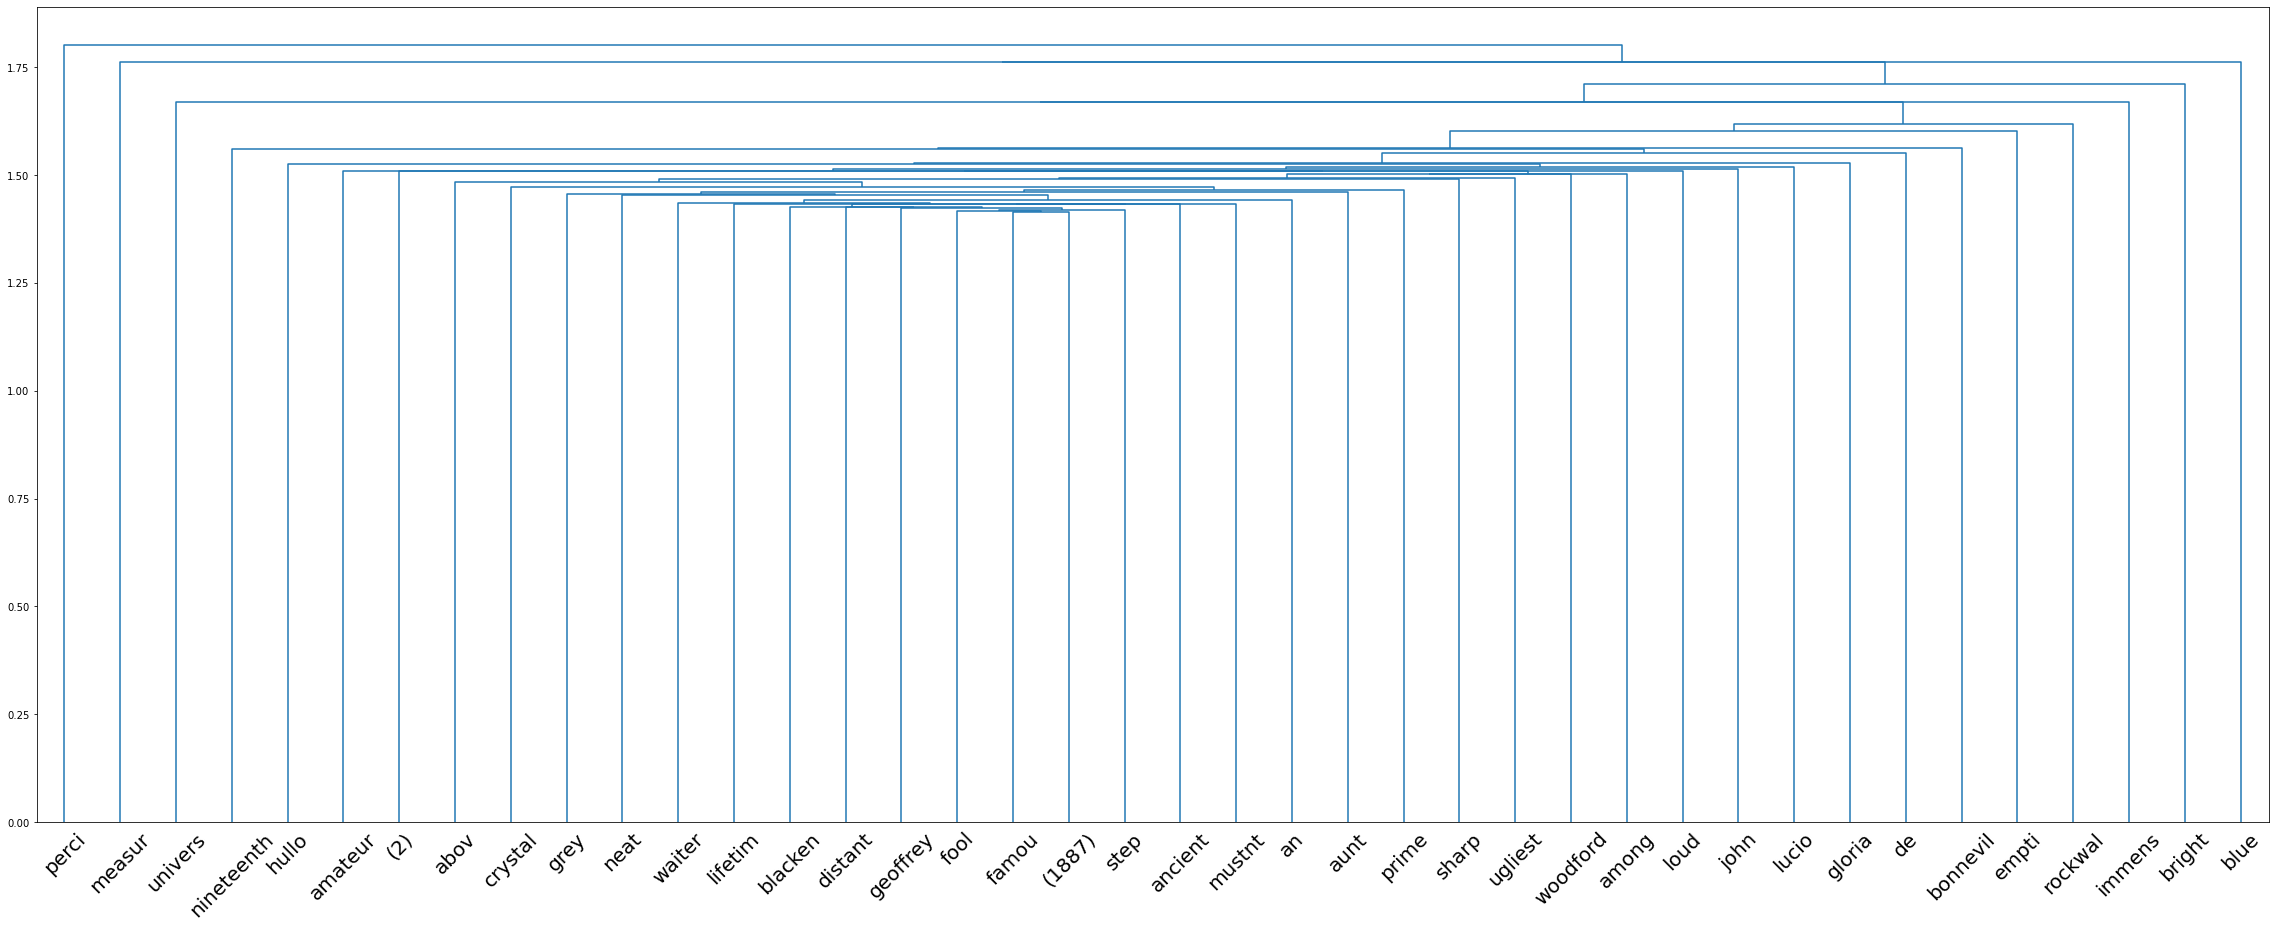

In [99]:
def plot_dendo(X, names, exclude=['<SOS>','<EOS>']):
    #  Show hierarchical clustering of vectors 
    #
    # Input
    #  X : numpy tensor [nitem x dim] such that each row is a vector to be clustered
    #  names : [length nitem] list of item names
    #  exclude: list of names we want to exclude       
    nitem = len(names)
    names  = np.array(names)
    include = np.array([myname not in exclude for myname in names], dtype=bool)
    linked = linkage(X[include],'single', optimal_ordering=True)
    plt.figure(figsize=(40,15))
    
    # truncate to show only 50 high level clusters
    n_clusters = 40
    dendrogram(linked, labels=names[include], color_threshold=0, leaf_font_size=20, truncate_mode='lastp', p=n_clusters)
    # dendrogram(linked, labels=names[include], color_threshold=0, leaf_font_size=8)
    plt.show()
    
    # plt.savefig("word_embeddings_dendrogram.png", dpi=300, bbox_inches='tight')

plot_dendo(rnn.get_embeddings(), unique_tokens)

In [88]:
def generate(rnn, maxlen=20):
    # TODO : YOUR CODE GOES HERE
    # concat = torch.cat((special_token, prob_tensor),0)

    with torch.no_grad():
        output = torch.tensor(1) # assume it starts with <SOS>
        hidden = rnn.initHidden()
        res = [index_to_token[output.item()]]
        for i in range(maxlen):
            output, hidden = rnn(output, hidden)
            m = torch.distributions.categorical.Categorical(torch.exp(output))
            output = m.sample()
            res.append(index_to_token[output.item()])
            if output.item() == 0:
                break
            
        print(" ".join(res))
# raise Exception('Replace with your code.')
    
for i in range(20):
    generate(rnn)

<SOS> lesson a boat when i thi bring again matter we appear on the box which cover a ben explain an
<SOS> the wrong have spent to hi doorbel build alway hi hard at all wrong beer <EOS>
<SOS> lesson are out when the idea of the ugliest monster have been near hi along those hat thi york plane
<SOS> you set not up in a plough besid the warm ride will have he hurri <EOS>
<SOS> lesson an by an forc and she chose balloon dream of been thought stori under if polit year <EOS>
<SOS> i he said hand on the futur mile drift english <EOS>
<SOS> after the holiday they had told me to the theatr <EOS>
<SOS> <EOS>
<SOS> they will school be tune in <EOS>
<SOS> sinc jenni i never open me <EOS>
<SOS> lesson an young <EOS>
<SOS> when glanc at the water it is said a bedsid modern tini peopl and find a assist park busi the
<SOS> the trip had just never turn that ten sweet <EOS>
<SOS> everybodi fewer all bed had to walk move that a new machin when a young is year and a lot
<SOS> at the snake wa yesterday as h